In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import pairwise_distances

In [2]:
pip install plotly

In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 81.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Loading the dataset:

In [4]:
csv_file_path = '/content/ratings_Electronics.csv.zip'

In [5]:
df = pd.read_csv('/content/ratings_Electronics.csv.zip',names=["userID", "productID", "rating", "timestamp"])

In [6]:
(df.head())

,userID,productID,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


Dropping timestamp column:

In [7]:
df= df.drop('timestamp', axis=1)

Limiting only 1000 users and products:

In [8]:
top_users = df['userID'].value_counts().index[:1000]
top_products = df['productID'].value_counts().index[:1000]
filtered_df = df[df['userID'].isin(top_users) & df['productID'].isin(top_products)]


In [9]:
user_codes = filtered_df['userID'].astype('category').cat.codes
product_codes = filtered_df['productID'].astype('category').cat.codes

In [10]:
sparse_matrix = csr_matrix((filtered_df['rating'], (user_codes, product_codes)))

In [11]:
user_similarity = cosine_similarity(sparse_matrix)

In [14]:
def recommend_products(user_id, user_similarity, sparse_matrix, top_n=5):
    user_idx = user_codes[filtered_df['userID'] == user_id].iloc[0]
    similarity_scores = user_similarity[user_idx]

    weighted_sum = sparse_matrix.T.dot(similarity_scores)


    recommendation = pd.DataFrame(weighted_sum, index=filtered_df['productID'].astype('category').cat.categories, columns=["score"])


    rated_products = filtered_df[filtered_df['userID'] == user_id]['productID']


    recommendation = recommendation[~recommendation.index.isin(rated_products)]

    return recommendation.sort_values("score", ascending=False).head(top_n)

In [17]:
top_users = df['userID'].value_counts().index[:5]
print(top_users)

Index(['A5JLAU2ARJ0BO', 'ADLVFFE4VBT8', 'A3OXHLG6DIBRW8', 'A6FIAB28IS79',
       'A680RUE1FDO8B'],
      dtype='object', name='userID')


In [20]:
user_id = 'A5JLAU2ARJ0BO'
top_recommendations = recommend_products(user_id, user_similarity, sparse_matrix)
print(top_recommendations)

                score
B0088CJT4U  36.956073
B00834SJNA  25.356128
B003ES5ZUU  23.001645
B0034CL2ZI  20.970595
B00834SJSK  20.838599


Creating sparse matrix

In [22]:
user_codes = filtered_df['userID'].astype('category').cat.codes
product_codes = filtered_df['productID'].astype('category').cat.codes
sparse_matrix = csr_matrix((filtered_df['rating'], (user_codes, product_codes)))

Converting sparse matrix to dense format for Pearson correlation:

In [23]:
user_product_matrix = sparse_matrix.toarray()

In [24]:
user_similarity_pearson = 1 - pairwise_distances(user_product_matrix, metric='correlation')

In [36]:
def recommend_pearson(user_id, user_similarity_pearson, sparse_matrix, top_n=5):
    user_idx = user_codes[filtered_df['userID'] == user_id].iloc[0]
    similarity_scores = user_similarity_pearson[user_idx]

    # Weighted sum of product ratings from similar users
    weighted_sum = sparse_matrix.T.dot(similarity_scores)

    # Convert sparse result back to DataFrame
    recommendation = pd.DataFrame(weighted_sum, index=filtered_df['productID'].astype('category').cat.categories, columns=["score"])

    # Get products rated by the user
    rated_products = filtered_df[filtered_df['userID'] == user_id]['productID']

    # Exclude already rated products
    recommendation = recommendation[~recommendation.index.isin(rated_products)]

    # Return top N recommended products
    return recommendation.sort_values("score", ascending=False).head(top_n)


In [29]:
top_recommendations_pearson = recommend_pearson('A5JLAU2ARJ0BO', user_similarity_pearson, sparse_matrix)
print(top_recommendations_pearson)

                score
B0088CJT4U  24.770880
B00834SJNA  18.484313
B0034CL2ZI  14.597054
B00834SJSK  14.410570
B004T9RR6I  13.040429


The above products are ranked based on the similarity scores claculated from the ratings of other users.

In [30]:
data = {
    'ASIN': ['B0088CJT4U', 'B00834SJNA', 'B0034CL2ZI', 'B00834SJSK', 'B004T9RR6I'],
    'score': [24.770880, 18.484313, 14.597054, 14.410570, 13.040429]
}

In [31]:
df = pd.DataFrame(data)

<ipython-input-35-fc8ff89f8676>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ASIN', y='score', data=df, palette='viridis')


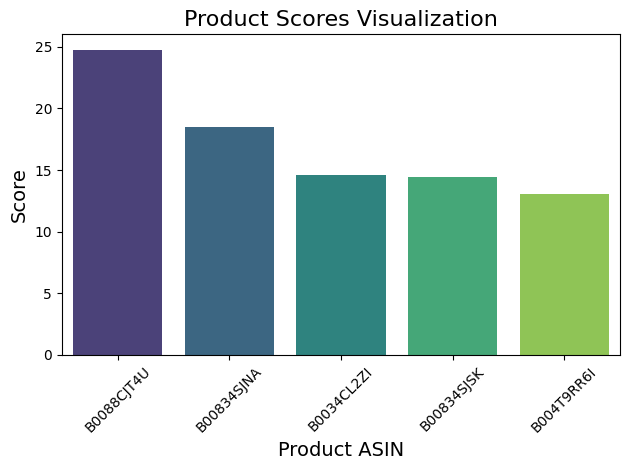

In [35]:
sns.barplot(x='ASIN', y='score', data=df, palette='viridis')
plt.title('Product Scores Visualization', fontsize=16)
plt.xlabel('Product ASIN', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()